# NLP TWEETS

#### Hello, We have divided the whole notebook into sections in the following order
#### 1) EDA
#### 2) PreProcessing
#### 3) Sentiment Analysis
#### 4) Entity Recognition
#### 5) Topic Modelling

We have here attached a CSV, which contains entities identified and sentiments predicted from our algorithms. Also the wordcloud and pyldavis visualization are attached as png because we executed that during runtime.



#### Results

Predicted Sentiments = col['is_there_an_emotion_directed_at_a_brand_or_product']<br>
Missing Entities or products towards emotions are directed at = col['emotion_in_tweet_is_directed_at']<br>
Topic Modelling = Topics visualized using i) Topic wise word distribution ii) LDA Visualization

In [2]:
# Including all the possible libraries required for whole processing

import pandas as pd
import re
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import seaborn as sns
import numpy as np
import string
import nltk
import chardet
import warnings
from ast import literal_eval
warnings.filterwarnings("ignore")
from nltk.stem import WordNetLemmatizer
#from wordcloud import WordCloud
from nltk.util import ngrams
from collections import Counter 
from nltk.tokenize import RegexpTokenizer, word_tokenize
from nltk.corpus import stopwords
from sklearn import model_selection, preprocessing, linear_model, naive_bayes, metrics, svm
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn import decomposition, ensemble
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation, NMF
from sklearn.model_selection import GridSearchCV
import pyLDAvis.sklearn
import pickle 
import pyLDAvis
from textblob import TextBlob

In [55]:
df=pd.read_csv(r"tweets.csv", encoding='iso8859-1')

In [239]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9093 entries, 0 to 9092
Data columns (total 3 columns):
tweet_text                                            9092 non-null object
emotion_in_tweet_is_directed_at                       3291 non-null object
is_there_an_emotion_directed_at_a_brand_or_product    9093 non-null object
dtypes: object(3)
memory usage: 213.2+ KB


In [240]:
df.head(5)

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
0,".@wesley83 I have a 3G iPhone. After 3 hrs tweeting at #RISE_Austin, it was dead! I need to upgrade. Plugin stations at #SXSW.",iPhone,Negative emotion
1,"@jessedee Know about @fludapp ? Awesome iPad/iPhone app that you'll likely appreciate for its design. Also, they're giving free Ts at #SXSW",iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. They should sale them down at #SXSW.,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as crashy as this year's iPhone app. #sxsw,iPad or iPhone App,Negative emotion
4,"@sxtxstate great stuff on Fri #SXSW: Marissa Mayer (Google), Tim O'Reilly (tech books/conferences) &amp; Matt Mullenweg (Wordpress)",Google,Positive emotion


Since we saw that there are non ascii charachters as well, we thought of checking if dataset is utf-8 encoded or not.

In [241]:
df['tweet_text'][9092]

'\x8cÏ¡\x8eÏà\x8aü_\x8b\x81Ê\x8b\x81Î\x8b\x81Ò\x8b\x81£\x8b\x81Á\x8bââ\x8b\x81_\x8b\x81£\x8b\x81\x8f\x8bâ_\x8bÛâRT @mention Google Tests \x89ÛÏCheck-in Offers\x89Û\x9d At #SXSW {link}'

In [242]:
with open("tweets.csv", 'rb') as rawdata:
    result = chardet.detect(rawdata.read(10000))

# check what the character encoding might be
print(result)

{'encoding': 'Windows-1254', 'confidence': 0.42136316173202365, 'language': 'Turkish'}


Turns out it is not utf8, hence we removed all non-ascii charachters

In [243]:
df['tweet_text'].replace({r'[^\x00-\x7F]+':''}, regex=True, inplace=True)
df['tweet_text'][9092]

'___RT @mention Google Tests Check-in Offers At #SXSW {link}'

### EDA

In [244]:
df['tweet_text']=df['tweet_text'].astype(str)

In [245]:
def find_retweeted(tweet):
    '''This function will extract the twitter handles of retweed people'''
    return re.findall('(?<=RT\s)(@[A-Za-z]+[A-Za-z0-9-_]+)', tweet)

def find_mentioned(tweet):
    '''This function will extract the twitter handles of people mentioned in the tweet'''
    return re.findall('(?<!RT\s)(@[A-Za-z]+[A-Za-z0-9-_]+)', tweet)  

def find_hashtags(tweet):
    '''This function will extract hashtags'''
    return re.findall('(#[A-Za-z]+[A-Za-z0-9-_]+)', tweet)  

In [246]:
df['retweeted'] = df.tweet_text.apply(find_retweeted)
df['mentioned'] = df.tweet_text.apply(find_mentioned)
df['hashtags'] = df.tweet_text.apply(find_hashtags)
df.head(5)

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product,retweeted,mentioned,hashtags
0,".@wesley83 I have a 3G iPhone. After 3 hrs tweeting at #RISE_Austin, it was dead! I need to upgrade. Plugin stations at #SXSW.",iPhone,Negative emotion,[],[@wesley83],"[#RISE_Austin, #SXSW]"
1,"@jessedee Know about @fludapp ? Awesome iPad/iPhone app that you'll likely appreciate for its design. Also, they're giving free Ts at #SXSW",iPad or iPhone App,Positive emotion,[],"[@jessedee, @fludapp]",[#SXSW]
2,@swonderlin Can not wait for #iPad 2 also. They should sale them down at #SXSW.,iPad,Positive emotion,[],[@swonderlin],"[#iPad, #SXSW]"
3,@sxsw I hope this year's festival isn't as crashy as this year's iPhone app. #sxsw,iPad or iPhone App,Negative emotion,[],[@sxsw],[#sxsw]
4,"@sxtxstate great stuff on Fri #SXSW: Marissa Mayer (Google), Tim O'Reilly (tech books/conferences) &amp; Matt Mullenweg (Wordpress)",Google,Positive emotion,[],[@sxtxstate],[#SXSW]


#### Trends with the Hashtags

In [247]:
hashtags_list=[]
df.hashtags.apply(lambda x: hashtags_list.extend(x))
unique_hashtags=list(set(hashtags_list))
len(unique_hashtags)

1678

In [248]:
# Finding the count of hastags in decreasing order
Counter(hashtags_list).most_common(10)


[('#sxsw', 4541),
 ('#SXSW', 4361),
 ('#Apple', 244),
 ('#iPhone', 215),
 ('#sxswi', 209),
 ('#iPad', 185),
 ('#google', 177),
 ('#apple', 171),
 ('#SxSW', 154),
 ('#iPad2', 153)]

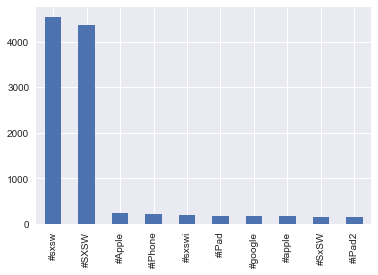

In [249]:
pd.Series(hashtags_list).value_counts()[:10].plot(kind="bar")

#### Trends with the Mentions

In [250]:
mentions_list=[]
df.mentioned.apply(lambda x: mentions_list.extend(x))
unique_mentions=list(set(mentions_list))
len(unique_mentions)

62

In [251]:
Counter(mentions_list).most_common(10)

[('@mention', 4273),
 ('@madebymany', 4),
 ('@garyvee', 3),
 ('@Schmittastic', 3),
 ('@jerranalley', 2),
 ('@tbalinas', 2),
 ('@mentionc', 2),
 ('@mentione', 2),
 ('@mentionR', 2),
 ('@iAmPaintedFace', 2)]

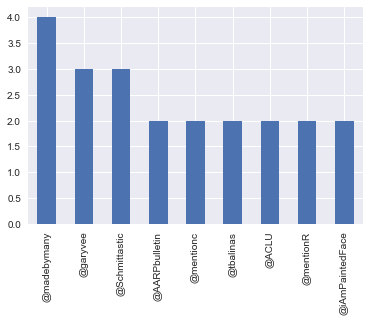

In [252]:
# we are going to ignore the mention @mention as it holds no value of significance
pd.Series(mentions_list).value_counts()[1:10].plot(kind="bar")

#### Count of entities in column B

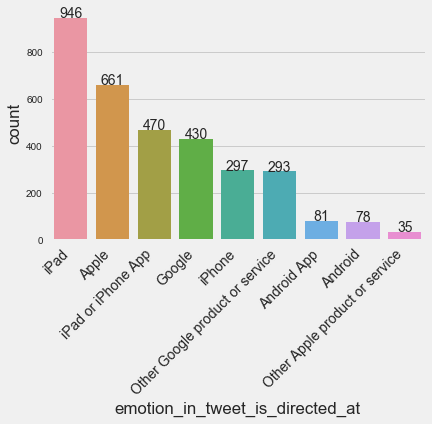

<Figure size 1008x432 with 0 Axes>

In [56]:
chart=sns.countplot(data=df, x='emotion_in_tweet_is_directed_at', order=df['emotion_in_tweet_is_directed_at'].value_counts().index)
#data
# labels=df['Category'].value_counts().index
# values=df['Category'].value_counts().values
plt.figure(figsize=(14,6))
chart.set_xticklabels(chart.get_xticklabels(), rotation=45, horizontalalignment='right', fontweight='light',fontsize='medium')
plt.tight_layout()
for i, p in enumerate(chart.patches):
    height = p.get_height()
    chart.text(p.get_x()+p.get_width()/2., height + 0.1,df['emotion_in_tweet_is_directed_at'].value_counts()[i],ha="center")
plt.show()

## PreProcessing

In [254]:
#removing entries where tweet text is not present
df = df.dropna(subset=['tweet_text'],axis=0)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9093 entries, 0 to 9092
Data columns (total 6 columns):
tweet_text                                            9093 non-null object
emotion_in_tweet_is_directed_at                       3291 non-null object
is_there_an_emotion_directed_at_a_brand_or_product    9093 non-null object
retweeted                                             9093 non-null object
mentioned                                             9093 non-null object
hashtags                                              9093 non-null object
dtypes: object(6)
memory usage: 497.3+ KB


In [255]:
# To remove any Links in the tweets
pd.set_option('display.max_colwidth', -1)
def remove_links(tweet):
    tweet = re.sub(r'http\S+', '', tweet) # remove http links
    tweet = re.sub(r'bit.ly/\S+', '', tweet) # rempve bitly links
    tweet = tweet.strip('{link}') # remove {links}
    return tweet

df['clean_tweet_text']=df['tweet_text'].apply(lambda x: remove_links(x))
df['clean_tweet_text'].head(5)

0    .@wesley83 I have a 3G iPhone. After 3 hrs tweeting at #RISE_Austin, it was dead!  I need to upgrade. Plugin stations at #SXSW.            
1    @jessedee Know about @fludapp ? Awesome iPad/iPhone app that you'll likely appreciate for its design. Also, they're giving free Ts at #SXSW
2    @swonderlin Can not wait for #iPad 2 also. They should sale them down at #SXSW.                                                            
3    @sxsw I hope this year's festival isn't as crashy as this year's iPhone app. #sxsw                                                         
4    @sxtxstate great stuff on Fri #SXSW: Marissa Mayer (Google), Tim O'Reilly (tech books/conferences) &amp; Matt Mullenweg (Wordpress)        
Name: clean_tweet_text, dtype: object

In [256]:
# To remove any Mentions in the tweets
def remove_users(tweet):
    tweet = re.sub('(RT\s@[A-Za-z]+[A-Za-z0-9-_]+)', '', tweet) # remove retweet
    tweet = re.sub('(@[A-Za-z]+[A-Za-z0-9-_]+)', '', tweet) # remove tweeted at
    return tweet

df['clean_tweet_text']=df['clean_tweet_text'].apply(lambda x: remove_users(x))
df['clean_tweet_text'].head(5)

0    . I have a 3G iPhone. After 3 hrs tweeting at #RISE_Austin, it was dead!  I need to upgrade. Plugin stations at #SXSW.    
1     Know about  ? Awesome iPad/iPhone app that you'll likely appreciate for its design. Also, they're giving free Ts at #SXSW
2     Can not wait for #iPad 2 also. They should sale them down at #SXSW.                                                      
3     I hope this year's festival isn't as crashy as this year's iPhone app. #sxsw                                             
4     great stuff on Fri #SXSW: Marissa Mayer (Google), Tim O'Reilly (tech books/conferences) &amp; Matt Mullenweg (Wordpress) 
Name: clean_tweet_text, dtype: object

In [257]:
#Lowercasing the tweet text
df['clean_tweet_text']=df['clean_tweet_text'].apply(lambda x: x.lower())
df['clean_tweet_text'].head(5)

0    . i have a 3g iphone. after 3 hrs tweeting at #rise_austin, it was dead!  i need to upgrade. plugin stations at #sxsw.    
1     know about  ? awesome ipad/iphone app that you'll likely appreciate for its design. also, they're giving free ts at #sxsw
2     can not wait for #ipad 2 also. they should sale them down at #sxsw.                                                      
3     i hope this year's festival isn't as crashy as this year's iphone app. #sxsw                                             
4     great stuff on fri #sxsw: marissa mayer (google), tim o'reilly (tech books/conferences) &amp; matt mullenweg (wordpress) 
Name: clean_tweet_text, dtype: object

In [258]:
# To remove Punctuation
punctuation = '!"$%&\'()*+,-./:;<=>?[\\]^_`{|}~•@#'
df['clean_tweet_text']=df['clean_tweet_text'].apply(lambda x: re.sub('['+punctuation + ']+', ' ', x))
df['clean_tweet_text'].head(5)

0      i have a 3g iphone  after 3 hrs tweeting at  rise austin  it was dead   i need to upgrade  plugin stations at  sxsw     
1     know about    awesome ipad iphone app that you ll likely appreciate for its design  also  they re giving free ts at  sxsw
2     can not wait for  ipad 2 also  they should sale them down at  sxsw                                                       
3     i hope this year s festival isn t as crashy as this year s iphone app   sxsw                                             
4     great stuff on fri  sxsw  marissa mayer  google  tim o reilly  tech books conferences   amp  matt mullenweg  wordpress   
Name: clean_tweet_text, dtype: object

In [259]:
# To remove Numbers
df['clean_tweet_text']=df['clean_tweet_text'].apply(lambda x: re.sub('(^\W)\d+', '', x))
df['clean_tweet_text']=df['clean_tweet_text'].apply(lambda x: re.sub('\d+', '', x))
df['clean_tweet_text'].head(5)

0      i have a g iphone  after  hrs tweeting at  rise austin  it was dead   i need to upgrade  plugin stations at  sxsw       
1     know about    awesome ipad iphone app that you ll likely appreciate for its design  also  they re giving free ts at  sxsw
2     can not wait for  ipad  also  they should sale them down at  sxsw                                                        
3     i hope this year s festival isn t as crashy as this year s iphone app   sxsw                                             
4     great stuff on fri  sxsw  marissa mayer  google  tim o reilly  tech books conferences   amp  matt mullenweg  wordpress   
Name: clean_tweet_text, dtype: object

In [262]:
# To remove single letter words
df['clean_tweet_text']=df['clean_tweet_text'].apply(lambda x: re.sub(' \w{1} |^\w{1} | \w{1}$', ' ', x))
df['clean_tweet_text'].head(5)

0     have iphone after hrs tweeting at rise austin it was dead need to upgrade plugin stations at sxsw                  
1     know about awesome ipad iphone app that you ll likely appreciate for its design also they re giving free ts at sxsw
2     can not wait for ipad also they should sale them down at sxsw                                                      
3     hope this year festival isn as crashy as this year iphone app sxsw                                                 
4     great stuff on fri sxsw marissa mayer google tim reilly tech books conferences amp matt mullenweg wordpress        
Name: clean_tweet_text, dtype: object

In [263]:
# To remove extra spacing
df['clean_tweet_text']=df['clean_tweet_text'].apply(lambda x: re.sub('\s+', ' ', x))
df['clean_tweet_text'].head(5)

0     have iphone after hrs tweeting at rise austin it was dead need to upgrade plugin stations at sxsw                  
1     know about awesome ipad iphone app that you ll likely appreciate for its design also they re giving free ts at sxsw
2     can not wait for ipad also they should sale them down at sxsw                                                      
3     hope this year festival isn as crashy as this year iphone app sxsw                                                 
4     great stuff on fri sxsw marissa mayer google tim reilly tech books conferences amp matt mullenweg wordpress        
Name: clean_tweet_text, dtype: object

In [264]:
def get_wordnet_pos(word):
    """
    Map POS tag to first character lemmatize() accepts
    """
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)

In [265]:
# To Lemmatize text with the appropriate POS tag
# lemmatizer = WordNetLemmatizer()
df['clean_tweet_tokens']=df.clean_tweet_text.apply(word_tokenize)
df['clean_tweet_tokens']=df['clean_tweet_tokens'].apply(lambda x: [lemmatizer.lemmatize(word, get_wordnet_pos(word)) for word in x])
df['clean_tweet_tokens'].head(5)

0    [have, iphone, after, hrs, tweeting, at, rise, austin, it, was, dead, need, to, upgrade, plugin, stations, at, sxsw]                      
1    [know, about, awesome, ipad, iphone, app, that, you, ll, likely, appreciate, for, its, design, also, they, re, giving, free, ts, at, sxsw]
2    [can, not, wait, for, ipad, also, they, should, sale, them, down, at, sxsw]                                                               
3    [hope, this, year, festival, isn, as, crashy, as, this, year, iphone, app, sxsw]                                                          
4    [great, stuff, on, fri, sxsw, marissa, mayer, google, tim, reilly, tech, books, conferences, amp, matt, mullenweg, wordpress]             
Name: clean_tweet_tokens, dtype: object

In [266]:
# To remove Stopwords
my_stopwords = nltk.corpus.stopwords.words('english')
word_rooter = nltk.stem.snowball.PorterStemmer(ignore_stopwords=False).stem
df['clean_tweet_tokens']=df['clean_tweet_tokens'].apply(lambda x: [word for word in x if word not in my_stopwords])
df['clean_tweet_tokens'].head(5)

0    [iphone, hrs, tweeting, rise, austin, dead, need, upgrade, plugin, stations, sxsw]                                       
1    [know, awesome, ipad, iphone, app, likely, appreciate, design, also, giving, free, ts, sxsw]                             
2    [wait, ipad, also, sale, sxsw]                                                                                           
3    [hope, year, festival, crashy, year, iphone, app, sxsw]                                                                  
4    [great, stuff, fri, sxsw, marissa, mayer, google, tim, reilly, tech, books, conferences, amp, matt, mullenweg, wordpress]
Name: clean_tweet_tokens, dtype: object

In [267]:
# To remove double letter words
df['clean_tweet_tokens']=df['clean_tweet_tokens'].apply(lambda x: [word for word in x if len(word)>2])
df['clean_tweet_tokens'].head(5)

0    [iphone, hrs, tweeting, rise, austin, dead, need, upgrade, plugin, stations, sxsw]                                       
1    [know, awesome, ipad, iphone, app, likely, appreciate, design, also, giving, free, sxsw]                                 
2    [wait, ipad, also, sale, sxsw]                                                                                           
3    [hope, year, festival, crashy, year, iphone, app, sxsw]                                                                  
4    [great, stuff, fri, sxsw, marissa, mayer, google, tim, reilly, tech, books, conferences, amp, matt, mullenweg, wordpress]
Name: clean_tweet_tokens, dtype: object

In [268]:
df['clean_tweet_text'] = df['clean_tweet_tokens'].apply(' '.join)
df['clean_tweet_text'].head(5)

0    iphone hrs tweeting rise austin dead need upgrade plugin stations sxsw                                  
1    know awesome ipad iphone app likely appreciate design also giving free sxsw                             
2    wait ipad also sale sxsw                                                                                
3    hope year festival crashy year iphone app sxsw                                                          
4    great stuff fri sxsw marissa mayer google tim reilly tech books conferences amp matt mullenweg wordpress
Name: clean_tweet_text, dtype: object

In [269]:
df.to_csv('tweets_clean_entity.csv', index=False)

## Sentiment Analysis

In [3]:
entity_df=pd.read_csv(r"tweets_clean_entity.csv", encoding='utf8')

In [4]:
entity_df


,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product,retweeted,mentioned,hashtags,clean_tweet_text,clean_tweet_tokens
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion,[],['@wesley83'],"['#RISE_Austin', '#SXSW']",iphone hrs tweeting rise austin dead need upgr...,"['iphone', 'hrs', 'tweeting', 'rise', 'austin'..."
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion,[],"['@jessedee', '@fludapp']",['#SXSW'],know awesome ipad iphone app likely appreciate...,"['know', 'awesome', 'ipad', 'iphone', 'app', '..."
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion,[],['@swonderlin'],"['#iPad', '#SXSW']",wait ipad also sale sxsw,"['wait', 'ipad', 'also', 'sale', 'sxsw']"
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion,[],['@sxsw'],['#sxsw'],hope year festival crashy year iphone app sxsw,"['hope', 'year', 'festival', 'crashy', 'year',..."
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion,[],['@sxtxstate'],['#SXSW'],great stuff fri sxsw marissa mayer google tim ...,"['great', 'stuff', 'fri', 'sxsw', 'marissa', '..."
5,@teachntech00 New iPad Apps For #SpeechTherapy...,NaN,No emotion toward brand or product,[],['@teachntech00'],"['#SpeechTherapy', '#SXSW', '#iear', '#edchat'...",new ipad apps speechtherapy communication show...,"['new', 'ipad', 'apps', 'speechtherapy', 'comm..."
6,NaN,NaN,No emotion toward brand or product,[],[],[],NaN,[]
7,"#SXSW is just starting, #CTIA is around the co...",Android,Positive emotion,[],[],"['#SXSW', '#CTIA', '#googleio', '#android']",sxsw starting ctia around corner googleio hop ...,"['sxsw', 'starting', 'ctia', 'around', 'corner..."
8,Beautifully smart and simple idea RT @madebyma...,iPad or iPhone App,Positive emotion,['@madebymany'],['@thenextweb'],"['#hollergram', '#sxsw']",beautifully smart simple idea wrote hollergram...,"['beautifully', 'smart', 'simple', 'idea', 'wr..."
9,Counting down the days to #sxsw plus strong Ca...,Apple,Positive emotion,[],[],['#sxsw'],counting days sxsw plus strong canadian dollar...,"['counting', 'days', 'sxsw', 'plus', 'strong',..."


Subjectivity of the tweet is done to find if the tweet is based on factual information or is formed from personal opinion or judgement. Higher subjectivity indicates higher presence of emotions in the text.
Whereas Polarity of the text is done to find out how positive, negative or neutral a text is.

In [ ]:
# get subjectivity of the tweet
def getSubjectivity(tweet):
    return TextBlob(tweet).sentiment.subjectivity

# ger polarity of the text
def getPolarity(tweet):
    return TextBlob(tweet).sentiment.polarity

entity_df['Subjectivity'] = entity_df['clean_tweet_tokens'].apply(getSubjectivity)
entity_df['Polarity'] = entity_df['clean_tweet_tokens'].apply(getPolarity)
entity_df

We are going to find out the sentiment of the tweet based on the polarity of the tweet.

In [9]:
def getAnalysis(score):
    if score < 0:
        return 'Negative emotion'
    elif score == 0:
        return 'No emotion toward brand or product'
    else:
        return 'Positive emotion'

entity_df['Analysis'] = entity_df['Polarity'].apply(getAnalysis)
entity_df['Analysis']

0                         Negative emotion
1                         Positive emotion
2       No emotion toward brand or product
3       No emotion toward brand or product
4                         Positive emotion
5                         Positive emotion
6       No emotion toward brand or product
7                         Positive emotion
8                         Positive emotion
9                         Positive emotion
10                        Positive emotion
11      No emotion toward brand or product
12                        Positive emotion
13                        Positive emotion
14                        Positive emotion
15                        Positive emotion
16      No emotion toward brand or product
17                        Positive emotion
18                        Positive emotion
19                        Positive emotion
20                        Positive emotion
21                        Positive emotion
22                        Positive emotion
23         

In [10]:
#Compare sentiment analysis of the algorithm with the provided values of sentiment
subdf= entity_df[(entity_df['is_there_an_emotion_directed_at_a_brand_or_product'] !='''I can't tell''' ) ]
subdf['is_equal'] = subdf['is_there_an_emotion_directed_at_a_brand_or_product'] == subdf['Analysis']
analysis = subdf['is_equal'].value_counts()
analysis
subdf

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product,retweeted,mentioned,hashtags,clean_tweet_text,clean_tweet_tokens,Subjectivity,Polarity,Analysis,is_equal
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion,[],['@wesley83'],"['#RISE_Austin', '#SXSW']",iphone hrs tweeting rise austin dead need upgr...,"['iphone', 'hrs', 'tweeting', 'rise', 'austin'...",0.400000,-0.200000,Negative emotion,True
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion,[],"['@jessedee', '@fludapp']",['#SXSW'],know awesome ipad iphone app likely appreciate...,"['know', 'awesome', 'ipad', 'iphone', 'app', '...",0.933333,0.466667,Positive emotion,True
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion,[],['@swonderlin'],"['#iPad', '#SXSW']",wait ipad also sale sxsw,"['wait', 'ipad', 'also', 'sale', 'sxsw']",0.000000,0.000000,No emotion toward brand or product,False
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion,[],['@sxsw'],['#sxsw'],hope year festival crashy year iphone app sxsw,"['hope', 'year', 'festival', 'crashy', 'year',...",0.000000,0.000000,No emotion toward brand or product,False
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion,[],['@sxtxstate'],['#SXSW'],great stuff fri sxsw marissa mayer google tim ...,"['great', 'stuff', 'fri', 'sxsw', 'marissa', '...",0.750000,0.800000,Positive emotion,True
5,@teachntech00 New iPad Apps For #SpeechTherapy...,NaN,No emotion toward brand or product,[],['@teachntech00'],"['#SpeechTherapy', '#SXSW', '#iear', '#edchat'...",new ipad apps speechtherapy communication show...,"['new', 'ipad', 'apps', 'speechtherapy', 'comm...",0.454545,0.136364,Positive emotion,False
6,NaN,NaN,No emotion toward brand or product,[],[],[],NaN,[],0.000000,0.000000,No emotion toward brand or product,True
7,"#SXSW is just starting, #CTIA is around the co...",Android,Positive emotion,[],[],"['#SXSW', '#CTIA', '#googleio', '#android']",sxsw starting ctia around corner googleio hop ...,"['sxsw', 'starting', 'ctia', 'around', 'corner...",0.350000,0.350000,Positive emotion,True
8,Beautifully smart and simple idea RT @madebyma...,iPad or iPhone App,Positive emotion,['@madebymany'],['@thenextweb'],"['#hollergram', '#sxsw']",beautifully smart simple idea wrote hollergram...,"['beautifully', 'smart', 'simple', 'idea', 'wr...",0.500000,0.107143,Positive emotion,True
9,Counting down the days to #sxsw plus strong Ca...,Apple,Positive emotion,[],[],['#sxsw'],counting days sxsw plus strong canadian dollar...,"['counting', 'days', 'sxsw', 'plus', 'strong',...",0.733333,0.433333,Positive emotion,True


In [11]:
#Find the tweets where the algorithms sentiment analysis does not match the provided sentiments
mismatchedAnalysis = subdf[(subdf['is_equal'] == False)]
mismatchedAnalysis.shape[0]

4322

In [12]:
print(TextBlob('can not wait for #ipad also they should sale them down at #sxsw').sentiment)

Sentiment(polarity=-0.15555555555555559, subjectivity=0.2888888888888889)


We have plotted the polarity and subjectivity to find out the distribution of the tweets based on sentiments. The middle line indicates all the neutral tweets, the dots of the right symbolizes the positive tweets and the dots on the left indicate the negative tweets.
This also highlights that the given data set has higher number of positive tweets.


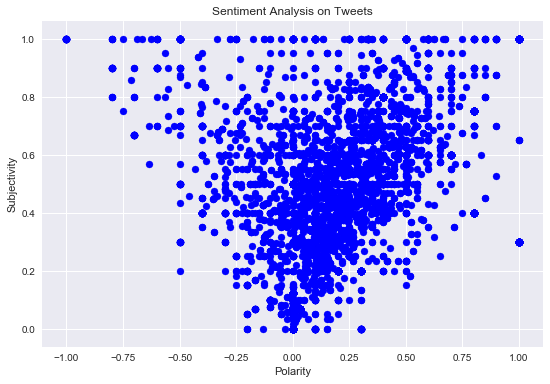

In [13]:
#Plot the polarity and subjectivity for better understanding
plt.figure(figsize=(8,6))
plt.scatter(entity_df['Polarity'], entity_df['Subjectivity'], color='Blue')
plt.title('Sentiment Analysis on Tweets')
plt.xlabel('Polarity')
plt.ylabel('Subjectivity')
plt.show()


In [14]:
# Get the percentage of positive tweets
ptweets = entity_df[entity_df.Analysis== 'Positive emotion']
ptweets = ptweets['clean_tweet_text']
print('Positive Tweets Percentage %f' %round ((ptweets.shape[0] / entity_df.shape[0]*100),1))

# Get the percentage of negative tweets
ptweets = entity_df[entity_df.Analysis== 'Negative emotion']
ptweets = ptweets['clean_tweet_text']
print('Negative Tweets Percentage %f' %round ((ptweets.shape[0] / entity_df.shape[0]*100),1))

# Get the percentage of neural tweets
ptweets = entity_df[entity_df.Analysis== 'No emotion toward brand or product']
ptweets = ptweets['clean_tweet_text']
print('Neutral Tweets Percentage %f' %round ((ptweets.shape[0] / entity_df.shape[0]*100),1))


Positive Tweets Percentage 49.100000
Negative Tweets Percentage 9.000000
Neutral Tweets Percentage 41.900000


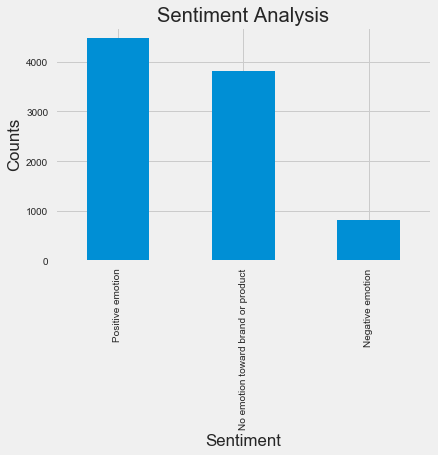

In [16]:
#Show the value counts
entity_df['Analysis'].value_counts()
plt.style.use('fivethirtyeight')

#plot and visualize the counts
plt.title('Sentiment Analysis')
plt.xlabel('Sentiment')
plt.ylabel('Counts')
entity_df['Analysis'].value_counts().plot(kind='bar')
plt.show()

The bar plot above indicates the 3 sentiments identified by the algorithm and also the value counts of each sentiment in the dataset.

In [17]:
#Updating the final results obtained by the algorithm in the column is_there_an_emotion_directed_at_a_brand_or_product of the dataframe and the csv.
entity_df['is_there_an_emotion_directed_at_a_brand_or_product'] = entity_df['Analysis']

del  entity_df['Analysis']
entity_df

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product,retweeted,mentioned,hashtags,clean_tweet_text,clean_tweet_tokens,Subjectivity,Polarity
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion,[],['@wesley83'],"['#RISE_Austin', '#SXSW']",iphone hrs tweeting rise austin dead need upgr...,"['iphone', 'hrs', 'tweeting', 'rise', 'austin'...",0.400000,-0.200000
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion,[],"['@jessedee', '@fludapp']",['#SXSW'],know awesome ipad iphone app likely appreciate...,"['know', 'awesome', 'ipad', 'iphone', 'app', '...",0.933333,0.466667
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,No emotion toward brand or product,[],['@swonderlin'],"['#iPad', '#SXSW']",wait ipad also sale sxsw,"['wait', 'ipad', 'also', 'sale', 'sxsw']",0.000000,0.000000
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,No emotion toward brand or product,[],['@sxsw'],['#sxsw'],hope year festival crashy year iphone app sxsw,"['hope', 'year', 'festival', 'crashy', 'year',...",0.000000,0.000000
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion,[],['@sxtxstate'],['#SXSW'],great stuff fri sxsw marissa mayer google tim ...,"['great', 'stuff', 'fri', 'sxsw', 'marissa', '...",0.750000,0.800000
5,@teachntech00 New iPad Apps For #SpeechTherapy...,NaN,Positive emotion,[],['@teachntech00'],"['#SpeechTherapy', '#SXSW', '#iear', '#edchat'...",new ipad apps speechtherapy communication show...,"['new', 'ipad', 'apps', 'speechtherapy', 'comm...",0.454545,0.136364
6,NaN,NaN,No emotion toward brand or product,[],[],[],NaN,[],0.000000,0.000000
7,"#SXSW is just starting, #CTIA is around the co...",Android,Positive emotion,[],[],"['#SXSW', '#CTIA', '#googleio', '#android']",sxsw starting ctia around corner googleio hop ...,"['sxsw', 'starting', 'ctia', 'around', 'corner...",0.350000,0.350000
8,Beautifully smart and simple idea RT @madebyma...,iPad or iPhone App,Positive emotion,['@madebymany'],['@thenextweb'],"['#hollergram', '#sxsw']",beautifully smart simple idea wrote hollergram...,"['beautifully', 'smart', 'simple', 'idea', 'wr...",0.500000,0.107143
9,Counting down the days to #sxsw plus strong Ca...,Apple,Positive emotion,[],[],['#sxsw'],counting days sxsw plus strong canadian dollar...,"['counting', 'days', 'sxsw', 'plus', 'strong',...",0.733333,0.433333


In [18]:
entity_df.to_csv('tweets_clean_entity.csv', index=False)

## Entity Recognition

This is where we fill the missing values for 'emotion_in_tweet_is_directed_at' column. Since it is text we won't be able to simply use Numpy but rather we had to use Classification approach and train our model with tweets having the entity labels to classify the tweets which have entity label as empty.

In [19]:
entity_df=pd.read_csv(r"tweets_clean_entity.csv", encoding='utf8')

In [20]:
entity_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9093 entries, 0 to 9092
Data columns (total 10 columns):
tweet_text                                            9092 non-null object
emotion_in_tweet_is_directed_at                       3291 non-null object
is_there_an_emotion_directed_at_a_brand_or_product    9093 non-null object
retweeted                                             9093 non-null object
mentioned                                             9093 non-null object
hashtags                                              9093 non-null object
clean_tweet_text                                      9091 non-null object
clean_tweet_tokens                                    9093 non-null object
Subjectivity                                          9093 non-null float64
Polarity                                              9093 non-null float64
dtypes: float64(2), object(8)
memory usage: 710.5+ KB


In [21]:
# Constructing train and test df based on emotion_directed_towards_entity field is present or not
entity_df = entity_df.dropna(subset=['clean_tweet_text'],axis=0)
train_df = entity_df[entity_df['emotion_in_tweet_is_directed_at'].notna()]
test_df = entity_df[entity_df['emotion_in_tweet_is_directed_at'].isnull()]

In [22]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3291 entries, 0 to 9088
Data columns (total 10 columns):
tweet_text                                            3291 non-null object
emotion_in_tweet_is_directed_at                       3291 non-null object
is_there_an_emotion_directed_at_a_brand_or_product    3291 non-null object
retweeted                                             3291 non-null object
mentioned                                             3291 non-null object
hashtags                                              3291 non-null object
clean_tweet_text                                      3291 non-null object
clean_tweet_tokens                                    3291 non-null object
Subjectivity                                          3291 non-null float64
Polarity                                              3291 non-null float64
dtypes: float64(2), object(8)
memory usage: 282.8+ KB


In [23]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5800 entries, 5 to 9092
Data columns (total 10 columns):
tweet_text                                            5800 non-null object
emotion_in_tweet_is_directed_at                       0 non-null object
is_there_an_emotion_directed_at_a_brand_or_product    5800 non-null object
retweeted                                             5800 non-null object
mentioned                                             5800 non-null object
hashtags                                              5800 non-null object
clean_tweet_text                                      5800 non-null object
clean_tweet_tokens                                    5800 non-null object
Subjectivity                                          5800 non-null float64
Polarity                                              5800 non-null float64
dtypes: float64(2), object(8)
memory usage: 498.4+ KB


In [24]:
# split the train dataset into training and validation datasets 
train_x, valid_x, train_y, valid_y = model_selection.train_test_split(train_df['clean_tweet_text'], train_df['emotion_in_tweet_is_directed_at'])

# label encode the target variable 
encoder = preprocessing.LabelEncoder()
train_y = encoder.fit_transform(train_y)
valid_y = encoder.fit_transform(valid_y)

We will vectorize our data in two ways based on whichever gives approach us the best results. The first approach is to use Count Vectorizer which constructs as many features as there are words, and the cell value is 0 or 1 depending on whether the word is present in a document or not. 

In [340]:
# create a count vectorizer object 
count_vect = CountVectorizer(analyzer='word', token_pattern=r'\w{1,}')
count_vect.fit(train_df['clean_tweet_text'])

# transform the training and validation data using count vectorizer object
xtrain_count=  count_vect.transform(train_x)
xvalid_count=  count_vect.transform(valid_x)


Whereas TF-IDF Vectorizer generates a score for each cell value in each row which is a combination of two factors: 1) Presence of each word in a document 2) No of documents with that word.
The features depends on whether we use words simply or we use ngrams (bigrams and trigrams to be specific)
So in short we have three different versions of feature vector list.

In [341]:
# word level tf-idf
tfidf_vect = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', max_features=5000)
tfidf_vect.fit(train_df['clean_tweet_text'])
xtrain_tfidf =  tfidf_vect.transform(train_x)
xvalid_tfidf =  tfidf_vect.transform(valid_x)

# ngram level tf-idf 
tfidf_vect_ngram = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', ngram_range=(2,3), max_features=5000)
tfidf_vect_ngram.fit(train_df['clean_tweet_text'])
xtrain_tfidf_ngram =  tfidf_vect_ngram.transform(train_x)
xvalid_tfidf_ngram =  tfidf_vect_ngram.transform(valid_x)

In [342]:
# Function to train different models and capture the accuracy for comparison
def train_model(classifier, feature_vector_train, label, feature_vector_valid):
    # fit the training dataset on the classifier
    classifier.fit(feature_vector_train, label)
    
    # predict the labels on validation dataset
    predictions = classifier.predict(feature_vector_valid)
    
    return metrics.accuracy_score(predictions, valid_y)

### Naive Bayes

In [343]:
# Naive Bayes on Count Vectors
accuracy = train_model(naive_bayes.MultinomialNB(), xtrain_count, train_y, xvalid_count)
print ("NB, Count Vectors: ", accuracy)

# Naive Bayes on Word Level TF IDF Vectors
accuracy = train_model(naive_bayes.MultinomialNB(), xtrain_tfidf, train_y, xvalid_tfidf)
print ("NB, WordLevel TF-IDF: ", accuracy)

# Naive Bayes on Ngram Level TF IDF Vectors
accuracy = train_model(naive_bayes.MultinomialNB(), xtrain_tfidf_ngram, train_y, xvalid_tfidf_ngram)
print ("NB, N-Gram Vectors: ", accuracy)

NB, Count Vectors:  0.7739975698663426
NB, WordLevel TF-IDF:  0.6488456865127582
NB, N-Gram Vectors:  0.669501822600243


### Linear Classifier

In [344]:
# Linear Classifier on Count Vectors
accuracy = train_model(linear_model.LogisticRegression(), xtrain_count, train_y, xvalid_count)
print ("LR, Count Vectors: ", accuracy)

# Linear Classifier on Word Level TF IDF Vectors
accuracy = train_model(linear_model.LogisticRegression(), xtrain_tfidf, train_y, xvalid_tfidf)
print ("LR, WordLevel TF-IDF: ", accuracy)

# Linear Classifier on Ngram Level TF IDF Vectors
accuracy = train_model(linear_model.LogisticRegression(), xtrain_tfidf_ngram, train_y, xvalid_tfidf_ngram)
print ("LR, N-Gram Vectors: ", accuracy)

LR, Count Vectors:  0.8456865127582017
LR, WordLevel TF-IDF:  0.8347509113001215
LR, N-Gram Vectors:  0.675577156743621


### Support Vector Machine

In [345]:
# SVM on Ngram Level TF IDF Vectors
accuracy = train_model(svm.SVC(), xtrain_tfidf_ngram, train_y, xvalid_tfidf_ngram)
print ("SVM, N-Gram Vectors: ", accuracy)

SVM, N-Gram Vectors:  0.6743620899149453


### Random Forest Classifier 

In [346]:
# RF on Count Vectors
accuracy = train_model(ensemble.RandomForestClassifier(), xtrain_count, train_y, xvalid_count)
print ("RF, Count Vectors: ", accuracy)

# RF on Word Level TF IDF Vectors
accuracy = train_model(ensemble.RandomForestClassifier(), xtrain_tfidf, train_y, xvalid_tfidf)
print ("RF, WordLevel TF-IDF: ", accuracy)

RF, Count Vectors:  0.8383961117861483
RF, WordLevel TF-IDF:  0.8262454434993924


### Hence we use Count Vectors to Vectorize our tweets and classify them into entities using Linear Classifier as that gave us maximum accuracy

In [25]:
# Constructing train and test df based on emotion_directed_towards_entity field is present or not
entity_df = entity_df.dropna(subset=['clean_tweet_text'],axis=0)
train_df = entity_df[entity_df['emotion_in_tweet_is_directed_at'].notna()]
test_df = entity_df[entity_df['emotion_in_tweet_is_directed_at'].isnull()]

In [26]:
# split the dataset into training and validation datasets 
train_x = train_df['clean_tweet_text']
train_y = train_df['emotion_in_tweet_is_directed_at']

# label encode the target variable 
encoder = preprocessing.LabelEncoder()
train_y = encoder.fit_transform(train_y)

In [27]:
valid_x = test_df['clean_tweet_text'].fillna(' ')

In [28]:
# create a count vectorizer object 
count_vect = CountVectorizer(analyzer='word', token_pattern=r'\w{1,}')
count_vect.fit(entity_df['clean_tweet_text'])

# transform the training and validation data using count vectorizer object
xtrain_count=  count_vect.transform(train_x)
xvalid_count=  count_vect.transform(valid_x)

In [29]:
model=linear_model.LogisticRegression()
model.fit(xtrain_count, train_y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [30]:
predictions = model.predict(xvalid_count)
test_df['emotion_in_tweet_is_directed_at']=encoder.inverse_transform(predictions)

In [31]:
df=pd.concat([train_df, test_df], ignore_index=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9091 entries, 0 to 9090
Data columns (total 10 columns):
tweet_text                                            9091 non-null object
emotion_in_tweet_is_directed_at                       9091 non-null object
is_there_an_emotion_directed_at_a_brand_or_product    9091 non-null object
retweeted                                             9091 non-null object
mentioned                                             9091 non-null object
hashtags                                              9091 non-null object
clean_tweet_text                                      9091 non-null object
clean_tweet_tokens                                    9091 non-null object
Subjectivity                                          9091 non-null float64
Polarity                                              9091 non-null float64
dtypes: float64(2), object(8)
memory usage: 710.3+ KB


In [32]:
entity_df.to_csv('tweets_clean_entity.csv', index=False)

## Topic Modelling

In [34]:
df=pd.read_csv(r"tweets_clean_entity.csv", encoding='utf8')

In [35]:
# To remove additional stopwords that might cause irrelevant words to come up in topic modelling
my_stopwords = nltk.corpus.stopwords.words('english')

df['clean_tweet_tokens']=df['clean_tweet_tokens'].apply(lambda x: literal_eval(str(x)))

necessary_removal=['link','sxsw','amp','quot','new','line','give','get','make','also','know','year','yet','never'\
                   ,'via','come','take','one','come','like','call','free','see','win','time','major','today','need'\
                  ,'open','think','party','cool','sxswi','temporary','use','day','check','possibly','look','people'\
                  ,'want','way','work','live','around','team','great','guy','set','tweet','thanks','beautifully'\
                  ,'simple','write','rumour','thanks','many','best','awesome','conference','include','pop','friend'\
                  ,'say','photo','let','last','first','wait','long','panel','rumor','valid','talk','keep','big'\
                  ,'yes','please','well','pic','love','good','show','temp','start','night','ready','show','anyone','join'\
                  ,'hand','still','week','buy','next','could','save','ever','com','world','event','nice','away','much','ask'
                  ,'must','head','right','hour','heard','everyone','everywhere','others','tonight','feel','every','learn'\
                  ,'booth','really','else','back','two','center','bar','type','follow','enjoy','already','try','person'\
                  ,'rank','hope','hear','might','even','left','turn','tomorrow','corner','skip','jump','daily','sure','someone'\
                  ,'lot','put','wow','place','tell','stuff','wish','share','watch','fun','find','would','street','hey','miss'\
                  ,'likely','appreciate','regularly','relies','fell','attend','begin','lose','change','bad','plan','phase','top'\
                  ,'help','attendee','brain','nerd','room','post','guide','stop','info','run','wonder','site','maybe','relief'\
                  ,'headache','may','another','detail','full','giveaway','enter','schedule','something','thing','bring','late'\
                  ,'convention','weekend','play','speak','happy','charge','rock','meet','seem','morning','mashable','pad','excite'\
                  ,'sign','white','smart','power','walk','festival','far','group','block','session','code','reward','update','idea'\
                  ,'tech','life','plenty','found','band','crowd','drink','experience','able','view','folk','view','saw','thought'\
                  ,'says','using','hrs','giving','got','made']
my_stopwords.extend(necessary_removal)
word_rooter = nltk.stem.snowball.PorterStemmer(ignore_stopwords=False).stem
df['clean_tweet_tokens']=df['clean_tweet_tokens'].apply(lambda x: [word for word in x if word not in my_stopwords])
df['clean_tweet_tokens'].head(5)

0    [iphone, tweeting, rise, austin, dead, upgrade...
1                          [ipad, iphone, app, design]
2                                         [ipad, sale]
3                                [crashy, iphone, app]
4    [fri, marissa, mayer, google, tim, reilly, boo...
Name: clean_tweet_tokens, dtype: object

In [36]:
tweets_text = [word for one_tweet in df['clean_tweet_tokens'] for word in one_tweet]

We will now see the frequency graph for NGrams across clean tweet text to get some sense on what is happening in the festival

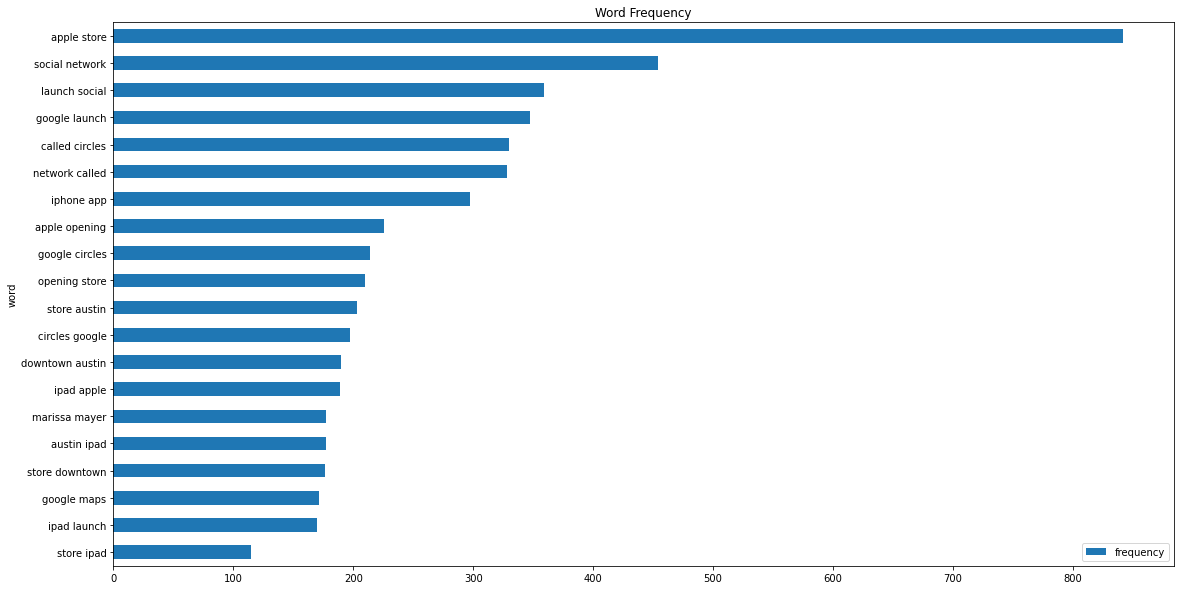

In [19]:
n_grams = list(ngrams(tweets_text, 2))
common_words = Counter(n_grams).most_common()
word_count = pd.DataFrame(data = common_words, 
                          columns=['word','frequency']) 
# Convert list to string
word_count['word'] = word_count['word'].apply(' '.join)
# Plot word count graph
word_count.head(20).sort_values('frequency').plot.barh(
        x='word', y='frequency', title='Word Frequency',figsize=(19,10))
plt.savefig('wordcount.png')

Below is a wordcloud giving us an idea on the frequency of words usage in the tweets.

In [6]:
# Convert DataFrame to Map so that word cloud can be generated from freq
word_count_dict = {}
for w, f in word_count.values:
    word_count_dict[w] = f
# Generate word cloud 
wordcloud = WordCloud(max_words=300, width=1400, height=900, 
                      random_state=12, contour_width=3, 
                      contour_color='firebrick')
wordcloud.generate_from_frequencies(word_count_dict)
plt.figure(figsize=(10,10), facecolor='k')
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")

<img src="wordcloud.png" />

In [37]:
#removing entries where tweet tokens is not present
df = df.dropna(subset=['clean_tweet_text'],axis=0)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9091 entries, 0 to 9090
Data columns (total 10 columns):
tweet_text                                            9091 non-null object
emotion_in_tweet_is_directed_at                       3291 non-null object
is_there_an_emotion_directed_at_a_brand_or_product    9091 non-null object
retweeted                                             9091 non-null object
mentioned                                             9091 non-null object
hashtags                                              9091 non-null object
clean_tweet_text                                      9091 non-null object
clean_tweet_tokens                                    9091 non-null object
Subjectivity                                          9091 non-null float64
Polarity                                              9091 non-null float64
dtypes: float64(2), object(8)
memory usage: 781.3+ KB


In [38]:
df['clean_tweet_text']=df['clean_tweet_tokens'].apply(lambda x: ' '.join(x))

In [39]:
# the vectorizer object will be used to transform text to vector form
vectorizer = CountVectorizer(max_df=0.9, min_df=25, token_pattern=r'\w{1,}')

# apply transformation
tf = vectorizer.fit_transform(df['clean_tweet_text']).toarray()

# tf_feature_names tells us what word each column in the matric represents
tf_feature_names = vectorizer.get_feature_names()

#to check the shape of tf
tf.shape

(9091, 325)

In [40]:
# the vectorizer object will be used to transform text to vector form
tfidf_vectorizer = TfidfVectorizer(max_df=0.9, min_df=25, token_pattern=r'\w{1,}')

# apply transformation
tfidf = tfidf_vectorizer.fit_transform(df['clean_tweet_text']).toarray()

# tf_feature_names tells us what word each column in the matric represents
tfidf_feature_names = tfidf_vectorizer.get_feature_names()

#to check the shape of tf
tfidf.shape

(9091, 325)

#### LDA

In [41]:
number_of_topics = 9

# Run LDA
lda = LatentDirichletAllocation(n_components=number_of_topics, max_iter=100, learning_method='online', learning_offset=50.,random_state=0).fit(tf)

In [48]:
pickle.dump(lda,open('lda_model_9_topics','wb'))

In [42]:
topic_dict = {}
for topic_idx, topic in enumerate(lda.components_):
    topic_dict["Topic %d words" % (topic_idx)]= ['{}'.format(tf_feature_names[i])
                    for i in topic.argsort()[:-5 - 1:-1]]
    topic_dict["Topic %d weights" % (topic_idx)]= ['{:.1f}'.format(topic[i])
                    for i in topic.argsort()[:-5 - 1:-1]]
topics=pd.DataFrame(topic_dict)

In [43]:
topics

,Topic 0 words,Topic 0 weights,Topic 1 words,Topic 1 weights,Topic 2 words,Topic 2 weights,Topic 3 words,Topic 3 weights,Topic 4 words,Topic 4 weights,Topic 5 words,Topic 5 weights,Topic 6 words,Topic 6 weights,Topic 7 words,Topic 7 weights,Topic 8 words,Topic 8 weights
0,going,214.6,iphone,1469.0,popup,208.1,google,243.8,google,1444.7,google,212.4,apple,2226.0,google,814.8,ipad,2020.7
1,technology,89.7,app,562.1,shop,139.8,music,147.8,circles,665.4,products,97.2,store,1376.4,mobile,286.0,app,149.1
2,designing,84.1,android,480.8,game,135.0,location,134.9,social,655.7,web,81.8,austin,947.9,maps,219.6,design,141.4
3,comes,52.1,apps,222.3,iphone,124.1,data,98.8,launch,473.7,getting,79.9,ipad,869.6,mayer,214.7,phone,109.6
4,days,51.4,blackberry,96.0,app,99.7,itunes,91.6,network,456.7,marketing,66.0,opening,254.7,marissa,189.8,better,69.1


#### NMF

In [49]:
number_of_topics = 9

# Run NMF
nmf = NMF(n_components=number_of_topics, random_state=1, alpha=.1, l1_ratio=.5, init='nndsvd').fit(tfidf)

In [50]:
topic_dict = {}
for topic_idx, topic in enumerate(nmf.components_):
    topic_dict["Topic %d words" % (topic_idx)]= ['{}'.format(tfidf_feature_names[i])
                    for i in topic.argsort()[:-5 - 1:-1]]
    topic_dict["Topic %d weights" % (topic_idx)]= ['{:.1f}'.format(topic[i])
                    for i in topic.argsort()[:-5 - 1:-1]]
topics=pd.DataFrame(topic_dict)

In [51]:
topics

,Topic 0 words,Topic 0 weights,Topic 1 words,Topic 1 weights,Topic 2 words,Topic 2 weights,Topic 3 words,Topic 3 weights,Topic 4 words,Topic 4 weights,Topic 5 words,Topic 5 weights,Topic 6 words,Topic 6 weights,Topic 7 words,Topic 7 weights,Topic 8 words,Topic 8 weights
0,store,7.6,google,8.6,ipad,9.7,iphone,8.1,circles,3.6,app,6.7,austin,6.5,android,6.2,apple,8.3
1,apple,1.5,maps,0.7,apps,0.3,apps,0.4,social,3.5,hollergram,0.4,opening,1.8,mobile,0.5,shop,0.8
2,popup,0.8,circles,0.5,design,0.3,game,0.4,network,3.4,download,0.4,downtown,1.7,apps,0.4,popup,0.4
3,opening,0.8,mayer,0.5,japan,0.2,case,0.3,launch,3.1,uberguide,0.3,launch,0.8,phone,0.4,begins,0.3
4,congress,0.7,mobile,0.5,launch,0.2,battery,0.3,called,2.8,ubersocial,0.3,heading,0.2,blackberry,0.3,wins,0.3


In [33]:
topics.to_csv('topics_nmf.csv', index=False)

#### LDA analysis to find the best number of topics
After comparing LDA models with different number of topics from range 5 to 20,
we emperically found out that number of topics = 9 was a good number for topics as it was able to distinctly identify different topics without overlapping different topics as well as without hiding smaller topics behind a bigger topic.

In [54]:
#number_of_topics = 9
#lda9 = LatentDirichletAllocation(n_components=number_of_topics, max_iter=100, learning_method='online', learning_offset=50.,random_state=0).fit(tf)
pyLDAvis.enable_notebook()
dtm = np.matrix(tf)
LDAvis_prepared= pyLDAvis.sklearn.prepare(lda, dtm, vectorizer, mds='tsne')
LDAvis_prepared


### LDA model visualized with n=9

<img src="LDA_VIS_n9.JPG"
     alt="LDA n=9"
     style="float: left; margin-right: 10px;" />


As you can see here we have observed the best parameters possible with LDA and implemented the model with those parameters. Along with this we also implemented NMF with similar parameters and observed the results as above.
The topics more or less are the same but the weightage of words inside the topic is different in both models with a minor redistribution of words here and there.
This difference arises from the fact that LDA uses count vectorizer and NMF uses tfidf vectorizer. Which implies that NMF also considers the distribution of words across documents instead of just the document. So if a word like sxsw is popular in all tweets, LDA will give it high weightage but NMF uses tfidf score meaning that a word which is highly occuring across all tweets might be popular but will very less likely be a topic of interest as its importance or score is inversely propotional to its occurence. And hence in case of NMF, words like hollergram, ubersocial are coming more at the top, which is what is of interest to us. Words like Austin are not so significant because we all know the fest is happening in Austin and hence it will occur frequenctly